# Parallel Hierarchical Affinity Propagation with MapReduce

***

## <a href="#1.-Hierachical-Affinity-Propagation-Algorithm" style="color:#00925B">1.&nbsp;&nbsp;The Hierachical Affinity Propagation Algorithm </a>
## <a href="#2.-Experiment-:-Mandrill" style="color:#00925B">2.&nbsp;&nbsp;Experiment : Mandrill </a>
## <a href="#3.-Map-Reduce-Hierarchical-Affinity-propagation" style="color:#00925B">3.&nbsp;&nbsp;Map Reduce Hierarchical Affinity propagation </a>
## <a href="#4.-Remarks" style="color:#00925B">4.&nbsp;&nbsp;Remarks </a>


## 1. Hierachical Affinity Propagation Algorithm

The HAP algorithm introduces levels of communication between the nodes such that : 


**1** - Some messages are the same as in the AP algorithm, but for each level $l \in \{1,..L\}$ : 
- "responsability" message from point i to point j: $\rho_{ij}^l$ (how suitable node i thinks node j is suitable to be its exemplar)

$$\rho_{ij}^l <- s_{ij}^l + min[\tau_i^{l}, \max_{k, k \neq j}\{\alpha_ik^{l} + s_{ik}^l \} ]$$

- "availability" message from point j to point i : $\alpha_{ij}^l$ (how available j is to be an examplar for data point i)

$$ \alpha_{ij}^{l<L} \leftarrow \min \{0, c_j^l + \phi_j^l + \rho_{jj}^l + \sum_{k, k \not\in \{i,j\}} max(0, \rho_{kj}^l) \} $$

$$ \alpha_{jj}^{l<L} \leftarrow  c_j^l + \phi_j^l + \sum_{k, k \not\in \{i,j\}} max(0, \rho_{kj}^l)  $$

- To avoid oscillations, we also use a damping step : $\lambda \in (0,1)$

**2** - Two new inter-level messages 
- messages $\tau$ which receives messages from the lower level : $$\tau_j^{l+1} = c_j^{l} + \rho_{jj}^l +\sum_{k, k \not\in \{i,j\}} \max(0, \rho_{kj}^l) $$

- messages $\phi$ which reveives message from the upper level :$$\phi_i^{l-1} = \max_k (\alpha_{ik}^l + s_{ik}^l) $$

**3** - At each level the cluster preference $c_i^l$ is updated 
$$c_i^l \leftarrow \max_{j} (\alpha{ij}^l + \rho_{ij}^l)$$

**4** - Update the similarity $s_{ij}^{l}$ : 

$$s_{ij}^{l+1} = s_{ij}^l + \kappa \max_{j, j\neq i} [\alpha_{ij}^l] + \rho_{ij}^l$$
where $\kappa \in [0,1]$

**5** - Final step : After all the assignments are done, one can extract the exemplars at each level:
$$e_i^l \leftarrow \arg \max_j \{\alpha{ij}^l + \rho_{ij}^l\} $$

**Pseudo-code of the Algorithm HAP :**

- **Input** : Similarity(S), Levels(L), Iterations, and $\lambda$

- **Initialization** : $\alpha = 0, \rho = 0, \tau = \infty, \phi = 0, c = 0, e=0 $

- **for** iter=1 $\rightarrow$ Iterations do

    - **for** l=1 $\rightarrow$ Levels do 
        Update $\rho_{ij}^l$ & Dampen $\rho^l$
        Update $\alpha_{ij}$ & Dampen $\alpha^l$
        Update $\tau_j^{l}$, $\phi_j^l$ & $c_j^l$ 
        **Optional** Update $s_{ij}^l$
     
     **end for** 
  
  **end for**

- **for** l=1 $\rightarrow$ Levels **do**

    Update $e_j^l$
    
    **end for**

In [2]:
#% load HAP.py
from HAP import HAP

## 2. Experiment : Mandrill

(266, 267, 3)


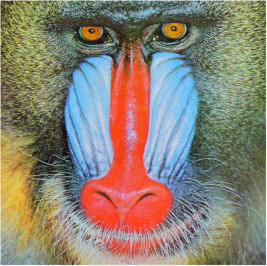

In [3]:
from PIL import Image
import numpy as np
im = Image.open("mandrill.png")
print(np.array(im).shape)
im

For the sake of this experiment, we will keep a smaller images (99x100). Remarques, as the number of parameters increased in $\mathcal{0}(n^2)$ the RAM of our computers were reached very quickly using this size of image (the same as in the paper)

(59, 60, 3)


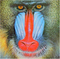

In [5]:
import matplotlib.pyplot as plt
import numpy as np

img=im
basewidth = 60
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
print(np.array(img).shape)
img

In [6]:
L = 5
img = np.array(img)
N = img.shape[0]*img.shape[1]
data = [row for row in np.array(img).reshape((img.shape[0]*img.shape[1],3))]

hap = HAP(data, L, N)

In [7]:
hap.fit(30)

In [8]:
def get_image(l):
        new_img = np.zeros((img.shape[0],img.shape[1],3), 'uint8')
        for coord, cluster in enumerate(hap.E[l,:]):
            x, y =int(coord//img.shape[1]),  int(coord%img.shape[1])
            color_x, color_y =  int(cluster//img.shape[1]), int(cluster%img.shape[1])
            new_img[x,y,:] = np.array(img)[ color_x, color_y,:]
        img_1 = Image.fromarray(new_img)
        return img_1

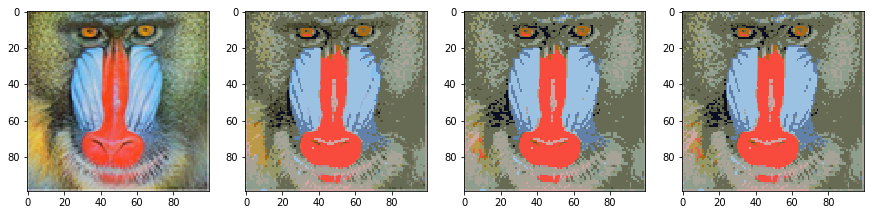

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(141)
plt.imshow(Image.fromarray(img))

plt.subplot(142)
plt.imshow(get_image(1))

plt.subplot(143)
plt.imshow(get_image(2))

plt.subplot(144)
plt.imshow(get_image(3))
plt.show()

## 3. Map Reduce Hierarchical Affinity propagation

**Notes** : 
- the algo must retain a copy of all times of the similarity S, availability $\alpha$, responsibiity $\rho$, cluster preferences c, $\tau$ and $\phi$ tensors 
- S, $\alpha$ and $\rho$ tensors contain $L\times N^2$ values where $N$ is the number of nodes and possible examplars and $L$ the number of levels (the three dimensions are the nodes, the examplars and the levels)
- c, $\tau$ and $\phi$ tensors contain $L\times N$ values (the three dimensions)

**MapReduce framework requires a (key, value) format, two options :** 

**1**- node-based format key = (node i, level l, tensor $\xi$) associated with the values : vectors of the ith node of the matrix on the lth level of the tensor

**2**- examplar-based format key = (examplar j, level l, tensor $\xi$) associated with the values : the vectors for the jth exemplar of the matrix on the lth level of the tensor

**Three MapReduce jobs :**

Loop over a set number of iter : 

- **1- First job** - Update $\rho$ (first for the first iteration), $\tau$, c ($\tau$ and c not updated during the first iteration but before after the first iteration) and switch the data to node-based format.

*Input*  = examplar-based format data
*Output* = node-based format data with updated values

*Mapper* :  Receives a unique key (j,l,$\xi$) and its value vector. Each index of the vector represents the nodes, so that the mapper iterates over the nodes i.

*Reducer* : Receives a key describing a unique (i,l) and a list of values which will be used to reconstruct the 6-node based vectors (??), the 2 node-based vectors(??) from the level below and the 2 speial diagonal vectors. Each index of the constructed vector are the examplars j, so that the iteration is on j. 


- **Switch to node-based format**

- **2-  Second job** -  Update $\phi$ and $\alpha$ and output the examplar-based format representation with updated values

*Mapper* : deconstructs exemplat-based vectors. Each mapper receive a key describing a unique (i,l,$\xi$) and the corresponding vector. Iterates over the vector with j

*Reducer* : receives a unique (j,l) combination and a list of values which will be used to reconstruct the 6 exemplar-based vectors and the 2 node-based vectors from the level above. The indices of the constructed vector represent the nodes so the reducer iterates over the vector with i. 


- **3-  Final job** - Extract the cluster assignments on each level. 
*Input* : examplar-based rep
*Output* : clusters assignments

*Mapper* : deconstructs the exemplar-based vectors into node-based values. Receives a key describing a unique (j, l, ξ) combination and a value with the corresponding vector. Iterate over i. 

*Reducer* : reconstruct node-based vectors. The last step => only the required info has to pass to the reducer and the other information can be neglected. Receives a key (i,l) combination and a list a values which will be used to reconstruct the 2 node-based vectors and the 2 special diagonal vectors. The reducer iterates over the vector with j.

In [ ]:
#% load MapReduce_HAP.py 
from MapReduce_HAP import MRHAP

(266, 267, 3)
(59, 60, 3)


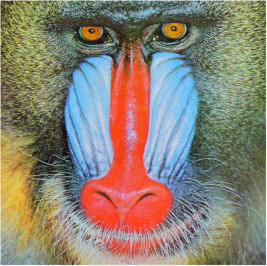

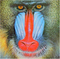

In [14]:
from PIL import Image
import numpy as np
import IPython.display as ipd
im = Image.open("mandrill.png")
print(np.array(im).shape)
img=im
basewidth = 60
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
print(np.array(img).shape)
ipd.display(im)
ipd.display(img)

In [4]:
L = 5
img = np.array(img)
N = img.shape[0]*img.shape[1]
data = [row for row in np.array(img).reshape((img.shape[0]*img.shape[1],3))]
mrhap = MRHAP(data, L, N, n_jobs = 6)

In [15]:
mrhap.fit(nb_iteration = 10)

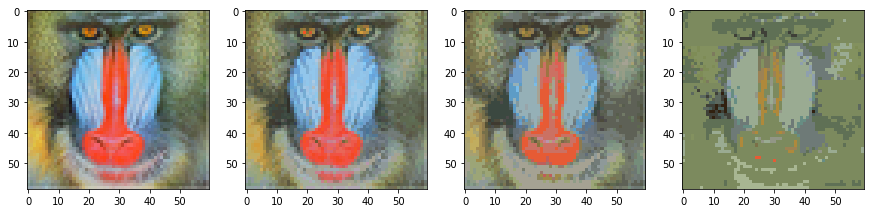

In [6]:
def get_image(E,l):
        new_img = np.zeros((img.shape[0],img.shape[1],3), 'uint8')
        for coord, cluster in enumerate(E[l,:]):
            x, y =int(coord//img.shape[1]),  int(coord%img.shape[1])
            color_x, color_y =  int(cluster//img.shape[1]), int(cluster%img.shape[1])
            new_img[x,y,:] = np.array(img)[ color_x, color_y,:]
        img_1 = Image.fromarray(new_img)
        return img_1
    
plt.figure(figsize=(15,5))
plt.subplot(141)
plt.imshow(Image.fromarray(img))

plt.subplot(142)
plt.imshow(get_image(mrhap.E,1))

plt.subplot(143)
plt.imshow(get_image(mrhap.E,2))

plt.subplot(144)
plt.imshow(get_image(mrhap.E,3))
plt.show()

## 4. Remarks

- the training of the MRHAP and the HAP is very memory consuming, it can take up to 8GB in memory (and barerly fit on the RAM of our local machine)
- No comparaison of the training time was done : the reason is that it is very long to run, especially the MR-HAP which seems longer to run than the standard one. It can seem a bit **suprising**, as it is the main reason why we want to implement the MRHAP algorithm. But in practise, as it is shown in the paper (see graph below), the trainig of the MR-HAP needs in reality lots of CPU's (we only have 6) to be better than the standard one. Indeed, in their experiments, the training time of the MP-HAP only outperforms the undistributed version for more than 20 EC2 GPU's, which is not easily reproducible here.

<img src="img/from_paper.png",width=600,height=600>